# Cohort Project 2021: Rydberg Atoms; Task 3

This notebook provides a solution for the "Rydberg" project (week 2) for the CDL cohort project of 2021. See the original Github repositiory [here](https://github.com/CDL-Quantum/CohortProject_2021).

## Instructions
This notebook has been designed to be used in a google colab environment which runs jupyter notebooks

For this task we will be looking at three different solutions to the Gotham City problem. The first way is using the classical optimization method from Task 1. I have gone ahead and copied the code from Task 1 into this notebook, as that will be our starting point.

### Problem Statement
The City of Gotham is looking at putting in new cell phone towers. The possible locations of the
cell phone towers are given in Fig. 2. The billionaire Bruce Wayne is funding the project and he
loves his money. Therefore, Gotham should only purchase the required number of cell phone towers
such that 1) the cell phone tower signal ranges do not overlap7
, and 2) as much of Gotham City
can be within cell signal range

### 1. Explain why this is a problem that can be easily mapped to the UD-MIS problem.

A UD-MIS

In [145]:
import numpy as np
import scipy as sc
from scipy.sparse import linalg
import matplotlib.pyplot as plt
import networkx as nx
from abstract_udmis import AbstractUDMIS
import openfermion as of

%matplotlib inline

In [3]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")

In [4]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, graph):
        super().__init__()
        self.u, self.graph = u, graph
        self.num_vertices = len(self.graph)
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
    
    def find_edges(self):
        #num_pairs = int(self.num_vertices*(self.num_vertices)*0.5)
        edges = np.zeros((self.num_vertices, self.num_vertices), dtype=bool)
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    edges[i,j] = True
                    edges[j,i] = True
                    
        return edges
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices-1):
            for j in range(i+1, self.num_vertices):
                
                # check if there is an edge
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                
            vertex_term += self.occupations[i]
        
        # missed the last vertex
        vertex_term += self.occupations[self.num_vertices-1]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices)        

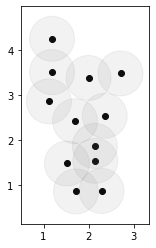

In [5]:
u = 1.35
graph = [(1.19, 4.25),(2.71, 3.48),
         (1.19, 3.51),(2, 3.38),
         (1.12, 2.86),(1.70, 2.42),
         (2.36, 2.54),(1.52, 1.48),
         (2.15, 1.54),(2.14, 1.87),
         (1.72, 0.86),(2.29, 0.87),
        ]

udmis = UDMIS(u, graph)

fig, ax = plt.subplots()
for i,occ in enumerate(udmis.occupations):
    c = 'red' if occ else 'black'
    x,y = graph[i]
    
    circle = plt.Circle((x,y), 0.5, color='grey', alpha=0.1)
    ax.add_patch(circle)
    
    plt.scatter(x, y, color='black', marker='o')
    
plt.gca().set_aspect(1)

### PART 2

Now we will solve the same proble, this time quantumly. To do this I will rewrite the juilia code that was used in the complete Task 2. The first thing that we will need to do is write the functions that will get the edges as well as the
Ω(t) and δ(t) functions from the equation. 

In [227]:
u = 1.35
Ω_max = 1.89
δ_0 = -1.0
δ_max = 1.0
dt = 0.0001
SampleSize = 20000
A = -(dt/sc.constants.h)
graph = [
    (1.19, 4.25),
    (2.71, 3.48),
    (1.19, 3.51),
    (2.0, 3.38),
    (1.12, 2.86),
    (1.70, 2.42),
    (2.36, 2.54),
    (1.52, 1.48),
    (2.15, 1.54),
    (2.14, 1.87),
    (1.72, 0.86),
    (2.29, 0.87)
]
edges= get_edges(graph)

def findall(edges,Nv):
    result = []
    for i in range(Nv):
        for j in range(Nv):
            if edges[i][j]:
                result.append([i,j])
    return result

def get_edges(graph):
    Nv = len(graph)
    edges = [([0]*Nv) for i in range(Nv)]
    for i in range(Nv-1):
        xi, yi = graph[i]
        for j in range(i+1,Nv):
            xj,yj = graph[j]
            
            dij = np.sqrt((xi-xj)**2. + (yi-yj)**2.)
            if dij <= 1.0:
                edges[i][j] = True
    return findall(edges,Nv)

def Ω(t):
    if 0<=t and t<=0.25:
        return (Ω_max / 0.25) * t
    elif 0.25< t and t<=0.69:
        return Ω_max
    elif 0.69 < t and t<=1:
        return - Ω_max * t / 0.31 + Ω_max * (1 + 0.69/0.31)
    
def δ(t):
    slope = (δ_0 - δ_max)/(0.25 - 0.69)
    if 0<=t and t<=0.25:
         return δ_0
    elif 0.25< t and t<=0.69:
        return t * slope + (δ_max - slope * 0.69)
    elif 0.69 < t and t<=1:
        return δ_max    

For this we will be construction our gates P1 and X tha will be used in the circuit

In [228]:
class P1(cirq.Gate):
    def __init__(self):
        super(P1,self)
        
    def num_qubits(self):
        return 1
    
    def _unitary_(self):
        return np.array([
            [0,0],
            [0,1]
        ])
    
    def _circuit_diagram_info_(self, args):
        return "P1"

class X_new(cirq.Gate):
    def __init__(self,constant,dt):
        super(X_new,self)
        self.constant = constant
        self.dt = dt
    def num_qubits(self):
        return 1
    
    def _unitary_(self):
        return np.array([
            [0,np.exp(-(1j/sc.constants.h)*self.constant*self.dt)],
            [np.exp(-(1j/sc.constants.h)*self.constant*self.dt),0]
        ])*self.constant
    
    def _circuit_diagram_info_(self, args):
        return "X_new"

### Quantum Circuit 

From the instructions we know that the hamiltoninan for this particular system can be written as $H(t) = Ω(t)\sum_{i \in V}σ_i^x -δ(t)\sum_{i \in V} n_i + u \sum_{i,j \in E} n_i n_j$. 
While the time evolution operator take the form of $U(t) = $ and the circuit is juat a combination of this time evolution operator on the initial state.

In [229]:
'''
The fisrt part of this is to build the hamiltonian. The hamiltonian for this circuit can be wittern as 
H(t) = Ω(t) ∑_i σ_i^x - δ(t) ∑_i n_i + u ∑_ij n_i n_j 
'''
def nn(q1,q2,u):
    m = []
    m.append(cirq.ops.CNOT(q1,q2))
    m.append(
         cirq.ops.LinearCombinationOfOperations({cirq.I(q2):u*A,cirq.rz(u*A).on(q2):1})
    )
    m.append(cirq.ops.CNOT(q1,q2))
    return m
    
def hamiltonian(graph,edges,t,qubits):
    Nv=len(graph)
    circuit = cirq.Circuit([])
    # 1. Ω(t) ∑_i σ_i^x
    circuit.append(cirq.rx(Ω(t)*A*2).on(qubits[i])for i in range(Nv))
    
    # 2. - δ(t) ∑_i n_i
    # remeber for this P1 = 0.5*(I - sigma_z) so this can be writen as a linear combination of gates
    circuit.append(
        cirq.ops.LinearCombinationOfOperations({cirq.I(qubits[i]):-δ(t)*A,cirq.rz(-δ(t)*A).on(qubits[i]):1})
        for i in range(Nv)
    )
    # 3. u ∑_ij n_i n_j 
    circuit.append(
        nn(qubits[edges[i][0]],qubits[edges[i][1]],u) for i in range(len(edges))
    )
    
    return circuit
        

def run_annealing(graph,edges,dt,SampleSize):
    Nv=len(graph)
    qubits = cirq.LineQubit.range(Nv)
    psi_t = cirq.Circuit([])
    for t in np.linspace(0,1,int(1/dt)):
        h = hamiltonian(graph, edges, t,qubits)
        psi_t.append(h) 
    psi_t.append([cirq.measure(q,key=f'q{count}') for count,q in enumerate(qubits)])
    result = cirq.Simulator().run(psi_t, repetitions=SampleSize)
    prob_df=result.data.groupby(result.data.columns.tolist(),as_index=False).size()
    prob_df['Probabilities']=prob_df['size']/SampleSize
    return prob_df
prod_df = run_annealing(graph, edges, dt,SampleSize)
prod_df
# print the row in the with the highest prob that will be our answer
answer = prod_df[prod_df.Probabilities == prod_df.Probabilities.max()]
print(answer)

     q0  q1  q2  q3  q4  q5  q6  q9  q7  q8  q10  q11  size  Probabilities
472   0   0   1   0   0   1   1   0   0   0    0    0    58         0.0029
